# This project shows how deep learning can be applied to detect wafer failure

This dataset (WM-811K) wafermap is collected from 47,543 lots in real-world fab. However, not all lots have perfect 25 wafer maps and it may caused by sensor failure or other unknown problems. So we only have 811,457 wafer maps in total

In [1]:
# import modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf


In [2]:
# import data
data = pd.read_pickle("/content/drive/MyDrive/Python 資料/Residual Network/LSWMD.pkl.zip (Unzipped Files)/LSWMD.pkl")

In [3]:
# check data information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


## Clean Data

###  Separate Training and Testing

In [4]:
'''
1. separate training and testing data
2. Because testing data is more than training, we use testing data to train a model and training data for testing purpose.
3. We found that there are totally 638,507 wafers have no labels.
'''

data_training = data[data['trianTestLabel']=='Training']  # num = 54,355
data_training.reset_index(drop=True, inplace=True)

data_testing = data[data['trianTestLabel']=='Test']  # num = 118,595
data_testing.reset_index(drop=True, inplace=True)


/usr/local/lib/python3.7/dist-packages/pandas/core/ops/array_ops.py:73: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)


- 172,950 wafers have labels
  - 25,519 wafers have real failure patterns
  - 147,431 wafers were still labeled none
- 638,507 wafers have no labels

### Dimension Check

We found that each image has different dimension and this could be a problem for classifcation!
Therefore, we need to transform image size to make the input the same dimension

In [5]:
def find_dim(x):
    return x.shape[0], x.shape[1]
    
data_training['waferMapDim'] = data_training.waferMap.apply(find_dim)
data_training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType,waferMapDim
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]],"(45, 48)"
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]],"(45, 48)"
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]],"(45, 48)"
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]],"(45, 48)"
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]],"(45, 48)"
...,...,...,...,...,...,...,...
54350,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1534.0,lot46729,21.0,[[Training]],[[none]],"(45, 43)"
54351,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1534.0,lot46729,22.0,[[Training]],[[none]],"(45, 43)"
54352,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1534.0,lot46729,23.0,[[Training]],[[none]],"(45, 43)"
54353,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1534.0,lot46729,24.0,[[Training]],[[none]],"(45, 43)"


In [6]:
# difference between largest and smallest image
max(data_training.waferMapDim), min(data_training.waferMapDim)

((212, 84), (15, 3))

In [7]:
# check the most common image dimension (25, 27)
data_training['waferMapDim'].value_counts()

(25, 27)    15684
(27, 25)     9235
(26, 26)     6369
(38, 36)     1877
(33, 37)     1804
            ...  
(67, 65)        1
(63, 63)        1
(52, 53)        1
(56, 63)        1
(53, 44)        1
Name: waferMapDim, Length: 335, dtype: int64

### Imbalance Check

In [8]:
def imbalance_check(data):
    '''
    1. Check number of samples in each failureType.
    '''
    Center=0; Donut=0; Edge_Loc=0; Edge_Ring=0; Loc=0; Random=0; Scratch=0; Near_full=0; none=0
    for i in data['failureType']:
        if i == 'Center':
            Center+=1
        elif i == 'Donut':
            Donut +=1
        elif i == 'Edge-Loc':
            Edge_Loc +=1
        elif i == 'Edge-Ring':
            Edge_Ring+=1
        elif i == 'Loc':
            Loc+=1
        elif i == 'Random':
            Random +=1
        elif i == 'Scratch':
            Scratch += 1
        elif i == 'Near-full':
            Near_full+=1
        elif i == 'none':
            none+=1
    print('Center:', Center, 'Donut:', Donut, 'Edge_Loc:', Edge_Loc, 'Edge_Ring:', Edge_Ring, 'Loc:', Loc, 'Random:', Random, 'Scratch:',Scratch, 'Near_full:', Near_full, 'none:',none)


imbalance_check(data_training)
imbalance_check(data_testing)

Center: 3462 Donut: 409 Edge_Loc: 2417 Edge_Ring: 8554 Loc: 1620 Random: 609 Scratch: 500 Near_full: 54 none: 36730
Center: 832 Donut: 146 Edge_Loc: 2772 Edge_Ring: 1126 Loc: 1973 Random: 257 Scratch: 693 Near_full: 95 none: 110701


### Transforming Images

In [9]:

class Data_func():
   '''
   This class is basic data functions, used to get exact training data for our model
   '''
   def __init__(self, data):
      self.data = data
      self.X = None
      self.Y = None
      

   def labelEncoding(self,):
      '''
      1. label-encoding failureType
      '''
      self.data['labels'] = self.data['failureType']
      mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
      self.data = self.data.replace({'labels':mapping_type})
      return None
   
   def resize_image(self, image):
      '''
      1. resize image to 28*28 
      '''
      resize_image = cv2.resize(image, (28, 28))
      return resize_image

   def get_data(self,):
      '''
      1. resize image all image in training data into same size
      2. one-hot encoding labels
      '''
      X = list()
      for i in self.data['waferMap']:
          if i.shape != (28, 28):
            image = self.resize_image(i)
            X.append(image)
          else:
            X.append(i)

      self.X = np.array(X).astype(np.float32) / 255.0  # normalize images
      #self.Y = pd.get_dummies(self.data['labels']).astype(np.float32).values # one-hot encoding
      self.Y = self.data['labels'].astype(np.int32).values  # convert to int

   def add_channel(self, x):
      return np.expand_dims(x, axis=3)


train = Data_func(data_training)
train.labelEncoding()
train.get_data()
train_x, train_y = train.X, train.Y


data_testing2 = data_testing.sample(frac=0.1,  replace=False, random_state = 1) # sample 10% of data from testing datset
test = Data_func(data_testing2)
test.labelEncoding()
test.get_data()
test_x, test_y = test.X, test.Y
   

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


### Visualization

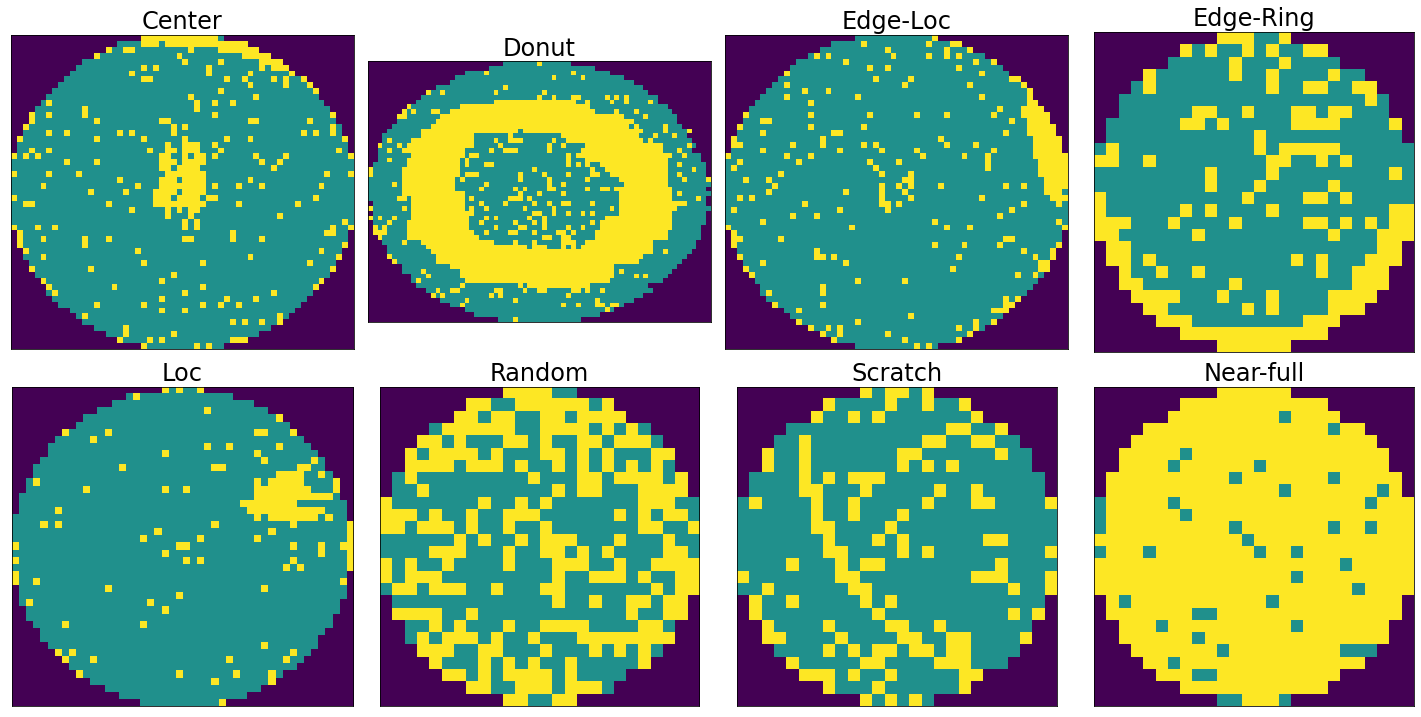

In [ ]:
'''
Failure Pattern Visualizaiton
'''

x = [9,340, 3, 16, 0, 25, 84, 37, ]
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Random','Scratch','Near-full', 'None']


fig, ax = plt.subplots(nrows = 3, ncols = 4, figsize=(20, 10))
ax = ax.ravel(order='C')
for i in range(9):
    img = df_withpattern.waferMap[x[i]]
    ax[i].imshow(img)
    ax[i].set_title(df_withpattern.failureType[x[i]][0][0],fontsize=24)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.tight_layout()
plt.show() 

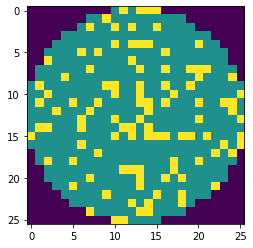

In [ ]:
'''
compare the original image to the resized-image
'''

a = data_training['waferMap'][385]
b = new.X[385]
# image before resizing
plt.imshow(a)


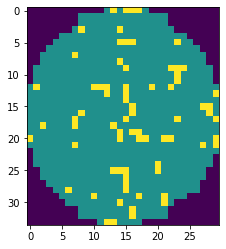

In [ ]:
# image after resizing
plt.imshow(b)

## CNN (Pytorch)

In [10]:
import torch
import torch.nn as nn

In [11]:
# Hyper-parameters
epoch = 30
batch_size = 500
learning_rate = 0.01
num_class = 9

In [12]:
# Put training data into DataLoader
train_data = torch.utils.data.TensorDataset(torch.unsqueeze(torch.from_numpy(train_x), dim=1), torch.from_numpy(train_y))
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = batch_size, shuffle=True)

# Add channel to testing data
test_x_torch = torch.autograd.Variable(torch.unsqueeze(torch.from_numpy(test_x), dim=1))
test_y_torch = torch.autograd.Variable(torch.from_numpy(test_y))

In [13]:
class CNN(nn.Module):
    '''
    define CNN structure
    '''
    def __init__(self, num_class):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(
              nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2),
              nn.BatchNorm2d(16)
        )

        self.conv2 = nn.Sequential(
              nn.Conv2d(in_channels=16, out_channels=30, kernel_size=5, stride=1, padding=2),
              nn.ReLU(),
              nn.MaxPool2d(kernel_size=2),
              nn.BatchNorm2d(30)
        )

        self.dense1 = nn.Linear(in_features= 30*7*7, out_features=50)
        self.dense1_bn = nn.BatchNorm1d(50)
        self.output = nn.Linear(in_features=50, out_features=num_class)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)

        x = x.view(x.size(0),-1) # flatten
        x = nn.functional.relu(self.dense1(x))
        x = self.dense1_bn(x)
        pre = nn.functional.log_softmax(self.output(x), -1)
        return pre



In [14]:
cnn = CNN(num_class)
print(cnn) # show structure of the model
# choose optimizer and loss function
optimizer = torch.optim.Adam(cnn.parameters(), lr= learning_rate)
loss_func = nn.CrossEntropyLoss()

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 30, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dense1): Linear(in_features=1470, out_features=50, bias=True)
  (dense1_bn): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (output): Linear(in_features=50, out_features=9, bias=True)
)


In [15]:

for e in range(epoch): # for each epoch
    for step, (x, y) in enumerate(train_loader): # for each mini-batch
        b_x = torch.autograd.Variable(x)
        b_y = torch.autograd.Variable(y)
        
        prediction = cnn(b_x)
        loss = loss_func(prediction, b_y.type(torch.LongTensor))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 100 == 0:
            test_output = cnn(test_x_torch)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == test_y_torch).sum().item() / float(test_y_torch.size(0))
            print('Epoch: ', e, '| train loss: %.4f' % loss.data, '| test accuracy: %.2f' % accuracy)


Epoch:  0 | train loss: 2.4345 | test accuracy: 0.30
Epoch:  0 | train loss: 0.1473 | test accuracy: 0.70
Epoch:  1 | train loss: 0.0757 | test accuracy: 0.71
Epoch:  1 | train loss: 0.1190 | test accuracy: 0.72
Epoch:  2 | train loss: 0.0988 | test accuracy: 0.70
Epoch:  2 | train loss: 0.0901 | test accuracy: 0.68
Epoch:  3 | train loss: 0.1062 | test accuracy: 0.73
Epoch:  3 | train loss: 0.0536 | test accuracy: 0.71
Epoch:  4 | train loss: 0.0838 | test accuracy: 0.72
Epoch:  4 | train loss: 0.0439 | test accuracy: 0.69
Epoch:  5 | train loss: 0.1003 | test accuracy: 0.71
Epoch:  5 | train loss: 0.0508 | test accuracy: 0.72
Epoch:  6 | train loss: 0.0625 | test accuracy: 0.74
Epoch:  6 | train loss: 0.0698 | test accuracy: 0.75
Epoch:  7 | train loss: 0.0564 | test accuracy: 0.69
Epoch:  7 | train loss: 0.0616 | test accuracy: 0.72
Epoch:  8 | train loss: 0.0667 | test accuracy: 0.73
Epoch:  8 | train loss: 0.0805 | test accuracy: 0.72
Epoch:  9 | train loss: 0.0256 | test accuracy

## CNN (Keras)

In [16]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPool2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Flatten

In [17]:
model = Sequential([
    
   Conv2D(filters=30, kernel_size=(3,3), kernel_initializer='he_uniform',input_shape=(28,28,1), activation = 'relu', padding='same'),
   MaxPooling2D(pool_size = (2,2)),
   Conv2D(filters = 30, kernel_size = (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
   MaxPooling2D(pool_size = (2,2)),
   Conv2D(filters = 30, kernel_size = (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
   MaxPooling2D(pool_size = (2,2)),
   Conv2D(filters = 30, kernel_size = (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'),
   MaxPooling2D(pool_size = (2,2)),
   
   Flatten(),
   Dense(units=1024, activation='relu', name="hidden_layer1"),
   
   Dense(units=1024, activation='relu', name="hidden_layer2"),
   Dense(units = 1, activation = 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 30)        300       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 30)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 30)        8130      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 30)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 30)          8130      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 30)         0

In [18]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
training_records = model.fit(
    train_x, train_y, batch_size=100, epochs=30, verbose=1,
    validation_data = (test_x, test_y)
)

Epoch 1/30
544/544 [==============================] - 14s 8ms/step - loss: 0.0000e+00 - accuracy: 0.0075 - val_loss: 0.0000e+00 - val_accuracy: 0.0010
Epoch 2/30
544/544 [==============================] - 4s 7ms/step - loss: 0.0000e+00 - accuracy: 0.0075 - val_loss: 0.0000e+00 - val_accuracy: 0.0010
Epoch 3/30
544/544 [==============================] - 4s 7ms/step - loss: 0.0000e+00 - accuracy: 0.0075 - val_loss: 0.0000e+00 - val_accuracy: 0.0010
Epoch 4/30
544/544 [==============================] - 4s 7ms/step - loss: 0.0000e+00 - accuracy: 0.0075 - val_loss: 0.0000e+00 - val_accuracy: 0.0010
Epoch 5/30
544/544 [==============================] - 4s 7ms/step - loss: 0.0000e+00 - accuracy: 0.0075 - val_loss: 0.0000e+00 - val_accuracy: 0.0010
Epoch 6/30
544/544 [==============================] - 3s 6ms/step - loss: 0.0000e+00 - accuracy: 0.0075 - val_loss: 0.0000e+00 - val_accuracy: 0.0010
Epoch 7/30
544/544 [==============================] - 3s 6ms/step - loss: 0.0000e+00 - accuracy: 0.

## ResNet